In [41]:
import boto3
import pandas as pd
import json


s3 = boto3.client(
    service_name='s3',
    aws_access_key_id='test',
    aws_secret_access_key='test',
    endpoint_url='http://localhost:4566',
)

In [43]:
# create bucket
bucket_name = 'images-msteams'

s3.create_bucket(Bucket= bucket_name)

{'ResponseMetadata': {'RequestId': '16e63fee-05f1-43c2-ae70-154dcff308e7',
  'HostId': 's9lzHYrFp76ZVxRcpX9+5cjAnEH2ROuNkd2BHfIa6UkFVdtjf5mKR3/eTPFvsiP/XV/VLi31234=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'TwistedWeb/24.3.0',
   'date': 'Sun, 09 Jun 2024 20:36:29 GMT',
   'location': '/images-msteams',
   'x-amz-request-id': '16e63fee-05f1-43c2-ae70-154dcff308e7',
   'x-amz-id-2': 's9lzHYrFp76ZVxRcpX9+5cjAnEH2ROuNkd2BHfIa6UkFVdtjf5mKR3/eTPFvsiP/XV/VLi31234=',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/images-msteams'}

In [45]:
response = s3.list_buckets()
pd.json_normalize(response['Buckets'])

,Name,CreationDate
0,images-msteams,2024-06-09 20:36:30+00:00


In [29]:
# run script

import logging
import random
from abc import ABC, abstractmethod
from datetime import datetime
from io import BytesIO
from urllib.parse import urlparse

import boto3
import pendulum
import psycopg2
import pymsteams
import requests
from airflow import DAG
from airflow.operators.empty import EmptyOperator
from airflow.operators.python import PythonOperator
from botocore.exceptions import BotoCoreError, NoCredentialsError
from psycopg2 import sql
from requests.exceptions import ConnectionError, HTTPError

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# AWS RDS
RDS_HOST = ".."
RDS_PORT = 5432
RDS_DB_NAME = "postgres"
RDS_USER = ".."
RDS_PASSWORD = ".."

TEAMS_WEBHOOK_URL = "your_webhook"  # TODO: store credentials in a secure way


class ContentGenerator(ABC):
    @abstractmethod
    def get_content(self):
        """ Method create connection to API and select random image/quote/etc."""
        pass


class QuoteGeneratorFromQuotableAPI(ContentGenerator):
    QUOTABLE_API_URL = "https://api.quotable.io/random"

    def get_content(self):
        response = requests.get(self.QUOTABLE_API_URL)

        if response.status_code != 200:
            logging.error("Failed to retrieve a quote")
            return None
        else:
            data = response.json()
            quote_text = data["content"]
            quote_author = data["author"]
            logging.info("A quote successfully generated.")

            return quote_text, quote_author


class ImageGeneratorFromPiscumAPI(ContentGenerator):
    WIDTH = random.randint(300, 800)
    HEIGHT = random.randint(300, 800)
    PISCUM_API_URL = "https://picsum.photos"

    def get_content(self):
        image_url = f"{self.PISCUM_API_URL}/{self.WIDTH}/{self.HEIGHT}"
        return image_url


class TeamsMessageSender:
    MESSAGE_COLOR = "#F8C471"

    def __init__(self, webhook_url):
        self.webhook_url = webhook_url

    def send_message(self, title, quote_text, quote_author, image_url):
        """Method combines the whole message and send it to MSTeams channel."""
        myTeamsMessage = pymsteams.connectorcard(self.webhook_url)
        myTeamsMessage.color(self.MESSAGE_COLOR)
        myTeamsMessage.title(title)
        myTeamsMessage.text(
            f"**Quote:** {quote_text}\n\n"
            f"**Author:** {quote_author}\n\n"
            f"![Image]({image_url})"
        )

        try:
            myTeamsMessage.send()
            logging.info("Message successfully sent.")
            return
        except (ConnectionError, HTTPError, TimeoutError) as e:
            logging.error(
                f"Failed to send message due to network error: {e}",
                exc_info=True
            )
        except pymsteams.TeamsWebhookException as e:
            logging.error(
                f"Failed to send message due to Teams webhook error: {e}",
                exc_info=True
            )
        except ValueError as e:
            logging.error(
                f"Failed to send message due to value error: {e}",
                exc_info=True
            )


class S3Loader:
    def __init__(self):
        self.s3_key = None
        self.s3_client = boto3.client(
            service_name='s3',
            aws_access_key_id='test',
            aws_secret_access_key='test',
            endpoint_url='http://localhost:4566',
        )

        self.bucket_name = "images-msteams"

    def extract_image_name(self, url):
        parsed_url = urlparse(url)
        img_name = parsed_url.path.split("/")[-1]
        return img_name

    def image_upload(self, image_url):
        try:
            response = requests.get(image_url)
            response.raise_for_status()
            image_data = response.content

            with BytesIO() as f:
                f.write(image_data)

            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

            image_name_from_url = self.extract_image_name(image_url)

            image_name = f"{image_name_from_url}_{timestamp}.jpg"
            s3_key = f"{image_name}"

            self.s3_client.put_object(
                Bucket=self.bucket_name,
                Key=s3_key,
                Body=image_data
            )
            s3_image_url = f"{self.s3_client.meta.endpoint_url}/{self.bucket_name}/{s3_key}"

            logging.info(f"Image successfully uploaded to S3: {s3_image_url}")
            return s3_image_url
        except (BotoCoreError, NoCredentialsError) as e:
            logging.error(
                f"Failed to upload image to S3: {e}",
                exc_info=True
            )
            return None


class RDSLoader:
    def __init__(self, host, port, dbname, user, password):
        self.conn = psycopg2.connect(
            host=host,
            port=port,
            dbname=dbname,
            user=user,
            password=password
        )
        self.check_table_exists()

    def check_table_exists(self):
        try:
            with self.conn.cursor() as cursor:
                cursor.execute("""
                                    CREATE TABLE IF NOT EXISTS daily_quotes (
                                        id SERIAL PRIMARY KEY,
                                        quote TEXT NOT NULL,
                                        quote_author TEXT NOT NULL,
                                        send_dt TIMESTAMP NOT NULL,
                                        picture_url TEXT NOT NULL,
                                        image_aws_s3_key TEXT NOT NULL
                                    )
                                """)
                self.conn.commit()
                logging.info("Ensured the quotes table exists.")

        except Exception as e:  # TODO: think about particular exceptions
            logging.error(f"Failed to ensure the quotes table exists: {e}")

    def load_quote(self, quote_text, quote_author, send_dt, image_url, s3_key):
        try:
            with self.conn.cursor() as cursor:
                insert_query = sql.SQL("""
                    INSERT INTO daily_quotes (quote, quote_author, send_dt, picture_url, image_aws_s3_key)
                    VALUES (%s, %s, %s, %s, %s)
                """)
                cursor.execute(
                    insert_query,
                    (
                        quote_text,
                        quote_author,
                        send_dt,
                        image_url,
                        s3_key
                    )
                )
                self.conn.commit()
                logging.info("Quote successfully saved to RDS.")
        except Exception as e:  # TODO: think about particular exceptions
            logging.error(f"Failed to save quote to RDS: {e}")


class MessageSenderExecutor:
    def __init__(self, quote_generator, image_generator, message_sender, s3_loader, rds_loader):
        self.quote_generator = quote_generator
        self.image_generator = image_generator
        self.message_sender = message_sender
        self.s3_loader = s3_loader
        self.rds_loader = rds_loader

    def run_process(self):
        quote_content = self.quote_generator.get_content()
        if not quote_content:
            logging.error("Failed to generate quote")
            return None

        quote_text, quote_author = quote_content

        image_url = self.image_generator.get_content()
        if not image_url:
            logging.error("Failed to generate image.")

        s3_image_url = self.s3_loader.image_upload(image_url)
        if not s3_image_url:
            logging.error("Failed to upload image to S3.")
            return None

        s3_key = self.s3_loader.extract_image_name(s3_image_url)

        self.message_sender.send_message(
            "Sent by Natalia Ananeva",
            quote_text,
            quote_author,
            s3_image_url
        )

        self.rds_loader.load_quote(
            quote_text,
            quote_author,
            datetime.now(),
            s3_image_url,
            s3_key
        )


# Create instances
quote_generator = QuoteGeneratorFromQuotableAPI()
image_generator = ImageGeneratorFromPiscumAPI()
message_sender = TeamsMessageSender(TEAMS_WEBHOOK_URL)
s3_loader = S3Loader()
rds_loader = RDSLoader(
    RDS_HOST,
    RDS_PORT,
    RDS_DB_NAME,
    RDS_USER,
    RDS_PASSWORD
)

# Run process
executor = MessageSenderExecutor(
    quote_generator,
    image_generator,
    message_sender,
    s3_loader,
    rds_loader
)
executor.run_process()

In [47]:
# check s3
bucket_name = 'images-msteams'

response = s3.list_objects_v2(Bucket=bucket_name)

if 'Contents' in response:
    print("Objects in the bucket:")
    for obj in response['Contents']:
        print(f"Key: {obj['Key']}, Content Type: {obj.get('ContentType', 'Unknown')}")
else:
    print("No objects found in the bucket.")

Objects in the bucket:
Key: 367_20240609223655.jpg, Content Type: Unknown


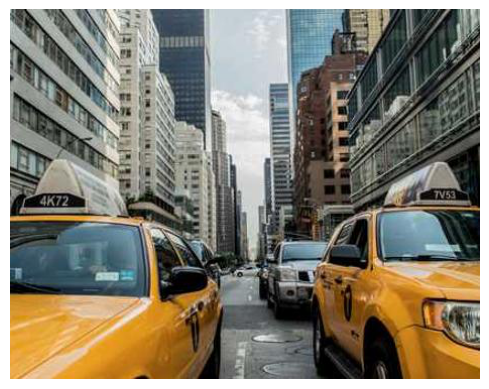

In [51]:
# print image from s3
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

image_key = '367_20240609223655.jpg'

response = s3.get_object(Bucket=bucket_name, Key=image_key)
image_data = response['Body'].read()

image = Image.open(BytesIO(image_data))

plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

# check AWS RDS 
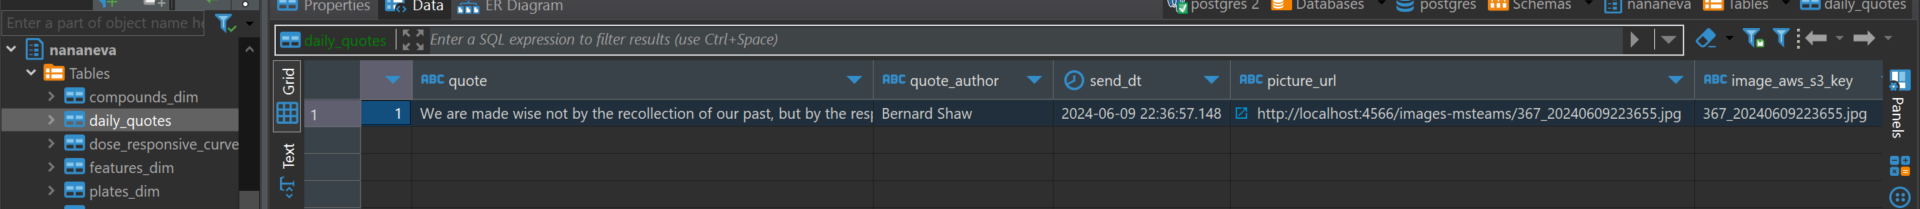
